<a href="https://colab.research.google.com/github/Srichitra-S/opencv/blob/master/gazebo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Custom object detector with Tensorflow and using it with OpenCV DNN module

In [1]:
#create folder TFOD
%cd TFOD

/content/TFOD


Installation and TFOD API setup

In [2]:
!pip install tensorflow==1.15.0
#!pip install youtube-dl
#!pip install pafy
!pip install scipy
!pip install labelImg
!pip install opencv-contrib-python
!pip install matplotlib

     |████████████████████████████████| 412.3MB 20kB/s 
     |████████████████████████████████| 3.8MB 9.4MB/s 
     |████████████████████████████████| 512kB 26.1MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=45c86302420a179bbc4dfc8b4fc9a6bd3f60f36e7d4450811d59da90692d835b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tenso

In [4]:
#import required libraries

import os
import shutil
import math
import datetime

import glob
import urllib
import tarfile
import urllib.request
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import re


import matplotlib.pyplot as plt
%matplotlib inline

# This will let you download any video from youtube
#import pafy

import cv2
import numpy as np

import tensorflow as tf

print("This should be Version 1.15.0, DETECTED VERSION: " + tf.__version__)

This should be Version 1.15.0, DETECTED VERSION: 1.15.0


Clone Tensorflow Object Detection Model Repository

1. Download with git

2. Download zip and extract all

In [5]:
# Clone the Github Repo in the current directory.
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 56138, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 56138 (delta 79), reused 143 (delta 55), pack-reused 55955
Receiving objects: 100% (56138/56138), 572.12 MiB | 32.09 MiB/s, done.
Resolving deltas: 100% (38693/38693), done.


Download protobuff compiler

TFOD contains some files in .proto format.

After downloading, unzip the proto folder, go to its bin directory and copy the proto.exe file. Paste it inside the models/research directory. 

In [6]:
#move to models/research
%cd models/research

/content/TFOD/models/research


Compiles protobuf files in the object detection/protos folder. 

Have a .py file for every proto file in protos folder


In [ ]:
!protoc object_detection\protos\*.proto --python_out=.

In [ ]:
#copies the required setup file to models folder and install requirements 
%cp object_detection/packages/tf1/setup.py .

In [7]:
# Installs and setsup TF 1 Object Detection API.
# have setup.py in models/research 
!python -m pip install .

Processing /content/TFOD/models/research
     |████████████████████████████████| 358kB 5.5MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1644171 sha256=f58813fdd74a144c35433b5662ce197af641099bff2a1a916bda16df222c769d
  Stored in directory: /tmp/pip-ephem-wheel-cache-j7v5gveb/wheels/fb/c1/dc/3b8dad8091e52f33a850885457d640ef0689c9fed57bb8e0f9
Successfully built object-detection


In [8]:
#move upto two directories back to TFOD directory
%cd ..
%cd ..

/content/TFOD/models
/content/TFOD


In [9]:
#check installation 
# Move to models/research directory.
%cd 'models/research'

# Test the installation.
!python object_detection/builders/model_builder_tf1_test.py

# back to the main directory
%cd ..
%cd ..

/content/TFOD/models/research
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_f

Data collection and annotation

1. Collect images from gazebo.
2. Annotate the images using labelImg.
3. Create a label map file
4. generate tfrecords

Make directory named training

Store images in training/images

Annotate images with labelimg and export in xml format. 
save it in training/labels

Inside the labels folder create a label map file

In [ ]:
# You can add more classes by adding another item and giving them an id of 3 and so on.


item {
    id: 1
    name: ''
}

item {
    id: 2
    name: ''
}



with open("training/label_map.pbtxt", "w") as text_file:
    text_file.write(pbtxt)

Generate TFrecords
What are TFrecords?

Tfrecords are just protocol buffers, they help make the data reading/processing process computationally efficient. The only downside they have is that they are not human readable.

What are protocol Buffers

Protocol buffer is a type of serialized structured data. It is more efficient then JSON, XML, pickle and text storage formats. Google created this Protobuf (protocol buffer) format in 2008 because of their efficiency, Since then they have been widely used by Google and the community. To read the protobuf files (.proto files) you will first need to compile them by a protobuf compiler. So now you probably understand why we needed to compile those proto files at the beginning.

Here's a nice tutorial by Naveen that explains how you can create a tfrecord for different data types and Here's a more detailed explanation of protocol buffers with an example.

The create_tf_record.py script I'll be using to convert images/labels to tfrecords is taken from the tensorflow's pet example but I've modified the script so now it accepts the following 5 arguments.

Directory of images
Directory of labels
% of Split of Training data
Path to label_map.pbtxt file
Path to output tfrecord files
And it returns a train.record and val.record. So it splits the training data into training/validation sets. For this data I'm using a training set of 70% and validation is 30%.

In [11]:
# Create tfrecords directory if it does not exits. This is where tfrecords will be stored.
#copy tf record.py inside tfrecords
%cd /content/TFOD/training/tfrecords
#if not os.path.exists(tf_reocords):
 #   os.mkdir(tf_reocords)

# We are saving the record files in the folder named tfrecords.
# Change the slashes (i.e. \\) according to your OS system.
# I'm using my own labels you can replace them with your labels.
!python create_tf_record.py --image_dir '/content/TFOD/training/images' --split 0.7 --labels '/content/TFOD/training/labels'   \
--output_path '/content/TFOD/training/tfrecords' --label_map  '/content/TFOD/training/label_map.pbtxt'

/content/TFOD/training/tfrecords
/usr/local/lib/python3.7/dist-packages/object_detection/utils/dataset_util.py:83: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:
Done Writing, Saved: /content/TFOD/training/tfrecords/train.record
Done Writing, Saved: /content/TFOD/training/tfrecords/val.record


<font style="color:rgb(220,100,20)">  Downloading Model & Configuring it </font>


### Download and unzip pre-trained model

You can now go to the [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md), select a model and download its zip. Now unzip the contents of that folder and put inside a directory named `pretrained_model`. Below script does this automatically for a Faster-RCNN-Inception model which is already trained on COCO dataset. You can change the model name to download a different model.


1. make a folder named pretrained_model
2. unzip contents of model zip file in this folder.

In [ ]:
# Specify pre-trained model name you want to download
MODEL = 'ssdlite_mobilenet_v2_coco_2018_05_09'

# Add the zip extension to the model
MODEL_FILE = MODEL + '.tar.gz'

# Define the base URL
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# If model directory is present then remove if for the new model
model_directory = "pretrained_model"
if os.path.exists(model_directory):
    shutil.rmtree(model_directory )

# Download the pretrained Model
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# Here we are extracting the downloaded file
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# Removing the downloaded zip file.
os.remove(MODEL_FILE)

# Rename model directory to pretrained_model
os.rename(MODEL, model_directory)

# Remove the checkpoint file so the model can be trained
os.remove(model_directory + '/checkpoint')

print('Model Downloaded')

Model Downloaded


### Modify pipline.config file

After downloading you will have a number of files present in the `pretrained_model` folder, I will explain about each of them later but for now let's take a look at the pipeline.config file.

`Pipeline.config` defines how the whole training process will take place, what optimizers, loss, learning_rate, batch_size will be used. Most of these params are already set by default, its up to you if you want to change them or not but there are some paths in the pipeline.config file that you will need to change so that this model can trained on our data.

So open up pipeline.config with a text editor like Notepad ++ and change these 4 paths:

- **Change:**  `PATH_TO_BE_CONFIGURED/model.ckpt`    **to**    `pretrained_model/model.ckpt`

- **Change:**  `PATH_TO_BE_CONFIGURED/mscoco_train.record`    **to**    `training/tfrecords/train.record`

- **Change:**  `PATH_TO_BE_CONFIGURED/mscoco_val.record`    **to**    `training/tfrecords/val.record`

- **Change:**  `PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt`    **to**    `training/label_map.pbtxt`

- **Change:**  `num_classes: 90`    **to**    `num_classes: 2`


If you're lazy like me then no prob, below script does all this 

In [ ]:
# Path of pipeline configuration file
filename = model_directory + '/pipeline.config'

# Open the configutation file and read the whole file
with open(filename) as f:
    s = f.read()
    
# Now find and subsitute the source paths with the destinations paths.    
with open(filename, 'w') as f:
    s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', model_directory + '/model.ckpt', s)
    s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record', 'training/tfrecords/train.record', s)
    s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record', 'training/tfrecords/val.record', s)
    s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', 'training/label_map.pbtxt', s)
    
    # Since we have 2 classes (Tom, Jerry) so we set this value to 2.
    s = re.sub('num_classes: 90', 'num_classes: 2', s)

    
    # Doing a little correction to avoid an error in training.
    s = re.sub('step: 0', 'step: 1', s)
            
    # I'm also changing the default batch_size of 1 to be 10 for this example
    s = re.sub('batch_size: 1', 'batch_size: 10', s)
    f.write(s)

*Notice the correction I did by replacing `step: 0` with `step: 1`, unfortunately for different models sometimes there are some corrections required but you can easily understand what exactly needs to be changed by pasting the error generated during training on google. Click on github issues for that error and you'll find a solution for that.*

*Note: These issues seems to be mostly present in TFOD API Version 1*

#### Changing Important Params in Pipeline.config File:

Additionally I've also changed the batch size of the model, just like batch_size there are lots of important parameters that you would want to tune. I would strongly recommend that you try to change the values according to your problem. Almost always the default values are not optimal for your custom use case. I should tell you that to tune most of these values you need some prior knowledge, make sure to atleast change the batch_size according to your system's memory and learning_rate of the model.

## <font style="color:rgb(220,100,20)">Part 5 Training and Exporting Inference Graph:  </font>

### Start Training the Model  

You can start training the model by calling the `model_main.py` script from the Object_detection folder, we are giving it the following arguments.

- **num_train_steps:** These are the number of times your model weights will be updated using a batch of data.

- **pipeline_config_path:** This is the path to your `pipeline.config` file.

- **model_dir:** Path to the output directory where the final checkpoint files will be saved.

Now you can run below cell to start training but I would recommend that you run this cell in the command line, you can just paste this line:

`python models/research/object_detection/model_main.py --pipeline_config_path="pretrained_model\pipeline.config" --model_dir="pretrained_model"  --num_train_steps=800`

### Training:


In [12]:
# Start Training

#change btach_norm = true in config file
!python '/content/TFOD/models/research/object_detection/model_main.py'  --pipeline_config_path="/content/TFOD/pretrained_model/pipeline.config" \
--model_dir="/content/TFOD/pretrained_model"  --num_train_steps=800 

W0419 08:54:39.498805 140570735982464 model_lib.py:812] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 800
I0419 08:54:39.499159 140570735982464 config_util.py:552] Maybe overwriting train_steps: 800
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0419 08:54:39.499321 140570735982464 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0419 08:54:39.499445 140570735982464 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0419 08:54:39.499564 140570735982464 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0419 08:54:39.499715 140570735982464 model_lib.py:828] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_tpu

Allocation of ---- exceeds 10% of system memory.

solution : change batch size to a small number.


***Note:*** *When you start training you will see a lot of warnings, just ignore them as TFOD 1 contains a lot of depreciated functions.*

Once you start training, the network will take some time to initialize and then the training will start, after every few minutes, you will see a report of loss values and a global loss. The Network is learning if the loss is going down. If you're not familiar with the Object detection Jargon Like `IOU` etc, then just make note of the final global loss after each report. 

You ideally want to set the `num_train_steps` to tens of thousands of steps, you can always end training by pressing `CTRL + C` on the command prompt if the loss has decreased sufficiently. If training is taking place in jupyter notebook then you can end it by pressing the Stop button on top.

After training has ended or you've stopped it, there would be some new files in the pre_trained folder. Among all these files we will only need the checkpoint (ckpt) files.

If you're training for 1000s of steps (*which is most likely the case*) then I would strongly recommend that you don't use your CPU but utilize a GPU. If you don't have one then its best to use Google Colab's GPU. I'm already providing you a ready to run colab Notebook.

**Note:** There's another script for training called train.py, this is an older script where you can see the loss value for each step, if you want to use that sicpt then you can find it at ***models / research / object_detection / legacy / train.py***

You can run this script by doing: 


```
python models/research/object_detection/legacy/train.py --pipeline_config_path="pretrained_model\pipeline.config" \
--train_dir="pretrained_model" ```

**The best way to monitor training is to use Tensorboard, I will discuss about this another time**

### Export Inference Graph
Now we will use the `export_inference_graph.py` script to create a frozen_inference_graph from the checkpoint files.

**Why are we doing this?**

After training the our model is stored in `checkpoint format` and a `saved_model` format but in OpenCV we need the model to be in a `frozen_inference graph` format. So we need to generate the frozen_inference_graph using the checkpoint files.

**What are these checkpoint files?**

After Every few minutes of training, tensorflow outputs some checkpoint (ckpt) files. The number on those files represent how many train steps they have gone through. So during the frozen_inference_graph creation we only take the latest checkpoint file (i.e. the file with the highest number) because this is the one which has gone through the most training steps.

Now every time a checkpoint file is saved, its split into 3 parts.

For the initial step these files are:

- **model.ckpt-000.data**: This file contains the value of each single variable, its pretty large.
- **model.ckpt-000.info**: This file contains metadata for each tensor. e.g. checksum, auxiliary data etc.
- **model.ckpt-000.meta**: This file stores the graph structure of the model

In [ ]:
# Get rid of any previous directory
#output_path = 'fine_tuned_model'
#if os.path.exists(output_path ):
#    shutil.rmtree(output_path )

# Get all the files present in the pretrained_model directory
#lst = os.listdir(model_directory)

# Get the most recent checkpoint file number.
#lf = filter(lambda k: 'model.ckpt-' in k, '/content/TFOD/pretrained_model')
#check = sorted([int(x.split('ckpt-')[1].split('.')[0]) for x in sorted(lf)[:]])[-1]

# Attach that number to model.ckpt- and pass it to the export script.
#checkpoint = 'model.ckpt-' + str(check)

# Run the export script, it takes the input_type, pipeline.config path,latest checpoint file name and  output path  
!python '/content/TFOD/models/research/object_detection/export_inference_graph.py'  \
--input_type image_tensor \
--pipeline_config_path '/content/TFOD/pretrained_model/pipeline.config'  \
--trained_checkpoint_prefix pretrained_model/$checkpoint \
--output_directory '/content/TFOD/fine_tuned_model' 

If you take a look at the fine_tuned_model then you'll find that it contains the same files you got when you downloaded the pre_trained model. This is the final folder.

Now Your trained model is in 3 different formats, the **saved_model** format, the **frozen_inference_graph** format and the **checkpoint file** format. For OpenCV we only need the frozen inference graph format.

The checkpoint format is ideal for retraining purposes and getting to know other sorts of information about the model, for production and serving the model you will need to use is either the `frozen_inference_graph` or `saved_model` format. Its worth mentioning that both these files contain the extension `.pb`

In TF 2, `frozen_inference_graph` is depreciated and TF 2 encourages to use the saved_model format, as said previously unfortunately we can't use the `saved_model` format with OpenCV yet.

### Run Inference on Trained Model (Bonus Step)
You can optionally choose to run inference using tensorflow sessions, I'm not going to explain much here as Tf sessions are depreciated and our final goal is to actually use this model in OpenCV DNN.

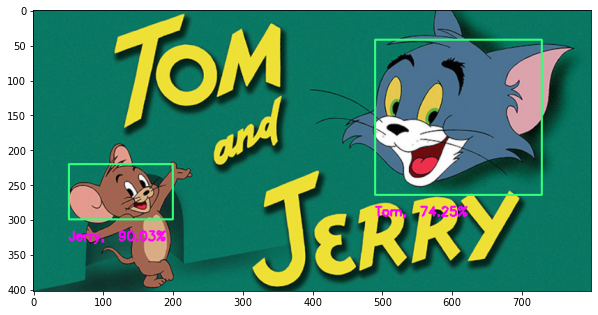

In [ ]:
# Use your trained Model
#frozen_graph_path = 'fine_tuned_model/frozen_inference_graph.pb'

# Use Our Trained Model
frozen_graph_path = 'support/frozen_inference_graph.pb'


# Read the graph.
with tf.gfile.FastGFile(frozen_graph_path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    
    # Set the defualt session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    # Read the Image
    img = cv2.imread('support/test_images/test7.jpg')
    
    # Get the rows and cols of the image.
    rows, cols = img.shape[:-1]
 
    inp = cv2.resize(img, (800, 800))
    
    # Convert OpenCV's BGR image to RGB
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

    # Run the model
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

    # These are the classes which we want to detect
    tf_classes = {1: "Jerry", 2: 'Tom'}
    
    # Get the total number of Detections
    num_detections = int(out[0][0])
    
    # Loop for each detection
    for i in range(num_detections):
        
        # Get the probability of that class
        score = float(out[1][0][i])
        
        # Check if the score of the detection is big enough
        if score > 0.400:
                                
            # Get their Class ID
            classId = int(out[3][0][i])

            # Get the bounding box coordinates of that class
            bbox = [float(v) for v in out[2][0][i]]
            
            # Get the class name
            class_name = tf_classes[classId]
            
            # Get the actual bounding box coordinates
            x1 = int(bbox[1] * cols)
            y1 = int(bbox[0] * rows)
            x2 = int(bbox[3] * cols)
            y2 = int(bbox[2] * rows)
            
          # Show the class name and the confidence
            text = "{},  {:.2f}% ".format(class_name, score*100)
            cv2.putText(img, text, (x1, y2+ 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                        (255,0,255), 2)
            
            # Draw the bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (125, 255, 51), thickness = 2)

# Show the image with matplotlib           
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1]);

## <font style="color:rgb(220,100,20)">Part 6:  Generating `.pbtxt` and using the trained model with just OpenCV  </font>

### Export Graph.pbxt with frozen inference graph:

We can use the above generated frozen graph inside the OpenCV DNN module to do detection but most of the time we need another file called a `graph.pbtxt` file. This file contains a description of the network architecture, it is required by OpenCV to rewire some network layers for Optimization purposes.

So the two files required to use a tensorflow model in OpenCV are: 

- **config:** Path to the .pbtxt file, this is the text graph description of the architecture of the model.

- **Model:** Path to the frozen_inferece_graph.pb file, this is your actual trained model, it contains all the weights/parameters of the model. 

This `graph.pbtxt` can be generated by using one of the 4 scripts provided by OpenCV. These scripts are:

- tf_text_graph_ssd.py
- tf_text_graph_faster_rcnn.py
- tf_text_graph_mask_rcnn.py
- tf_text_graph_efficientdet.py

They can be [downloaded here](https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API), you will also find more information regarding them on that page.

Now since the Detection architecture we're using is `Faster-RCNN` (*you can tell by looking at the name of the downloaded model*) so we will use `tf_text_graph_faster_rcnn.py` to generate the pbtxt file. For `.pbtxt` generation you will need the `frozen_inference_graph.pb` file and the `pipeline.config` file.

**Note:** When you're done with training then you will also see a `graph.pbtxt` file inside the pretrained folder, this `graph.pbtxt` is different from the one generated by OpenCV's `.pbtxt` genereator scripts. One major difference is that the OpenCV's `graph.pbtxt` do not contain the model weights but only contains the graph description, so they will be much smaller in size.